# Statistiques Descriptives simples

**L'objectif de cette partie est d'analyser la base de données à la réception de cette dernière. Voici les principales questions auxquelles nous souhaitons apporter des réponses :**
- **Quelles sont les catégories les plus représentées ?**
- **Comment les festivals se répartissent suivant leur localisation (est ce que certains types de festivals sont plus présents dans certaines parties de la France) ?**
- **Comment les festivals se répartissent suivant leur date (par ex. est ce que les festivals de musiques sont plus présents en été, avec une possible explication qu'ils se déroulent en extérieur ?) ?**


In [1]:
# Importer le fichier comme un module
from Nettoyage_base_donnees import df

# Vérifier le contenu du DataFrame
print(df.head())

           ﻿Nom du festival Envergure territoriale  \
0          Festival andalou              Régionale   
1  Festival Rêves d'enfants                    NaN   
2      Printemps de Paroles                    NaN   
3                 Pharaonic                    NaN   
4           Sarcus Festival                    NaN   

  Région principale de déroulement Département principal de déroulement  \
0       Provence-Alpes-Côte d'Azur                             Vaucluse   
1       Provence-Alpes-Côte d'Azur                         Hautes-Alpes   
2                    Île-de-France                       Seine-et-Marne   
3             Auvergne-Rhône-Alpes                               Savoie   
4              Centre-Val de Loire                       Indre-et-Loire   

  Commune principale de déroulement  \
0                           Avignon   
1                          Briançon   
2                Bussy-Saint-Martin   
3                          Chambéry   
4              Chemillé-sur-I

### 0. Prérequis

In [2]:
import subprocess
import sys

# Fonction pour installer les packages nécessaires
def install_packages():
    packages = [
        "pandas",
        "geopandas",
        "matplotlib",
        "cartiflette"
    ]
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"{package} installé avec succès.")
        except subprocess.CalledProcessError:
            print(f"Erreur lors de l'installation de {package}.")

# Appeler la fonction pour installer les packages
if __name__ == "__main__":
    install_packages()


pandas installé avec succès.
geopandas installé avec succès.
matplotlib installé avec succès.
cartiflette installé avec succès.


## I. Catégories les plus représentées 

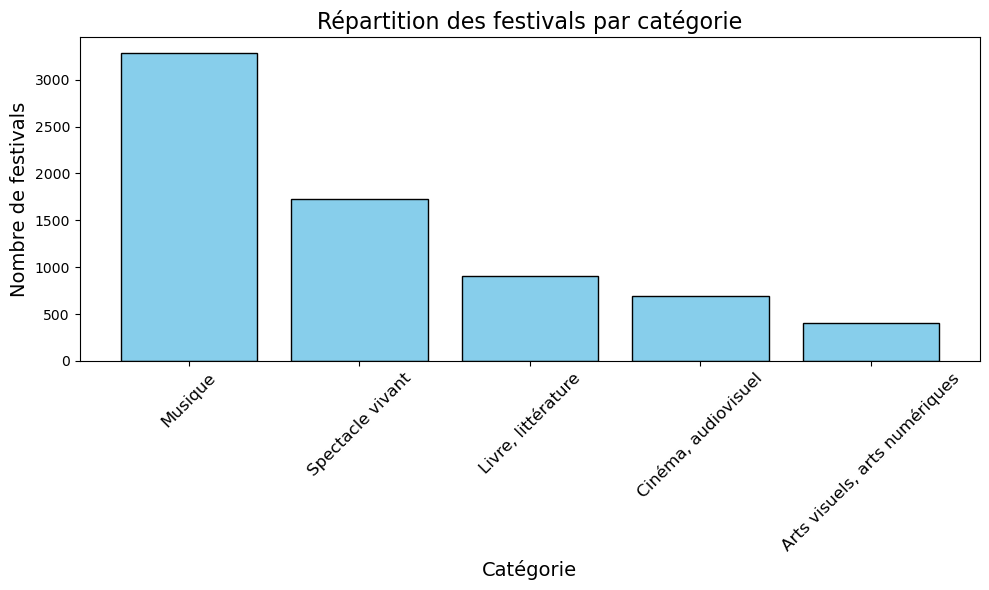

                       Catégorie  Nombre
0                        Musique    3287
1               Spectacle vivant    1722
2             Livre, littérature     905
3            Cinéma, audiovisuel     688
4  Arts visuels, arts numériques     399


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Catégories possibles
categories = [
    "Musique",
    "Spectacle vivant",
    "Livre, littérature",
    "Cinéma, audiovisuel",
    "Arts visuels, arts numériques"
]

def compter_categories_et_histogramme(df):
    """
    Compte les occurrences des catégories dans la colonne 'Discipline dominante'
    et crée un histogramme.
    """
    # Initialiser un dictionnaire pour compter les catégories
    category_counts = {category: 0 for category in categories}
    
    # Parcourir chaque ligne et compter les catégories
    for disciplines in df["Discipline dominante"]:
        if pd.notna(disciplines):  # Vérifier que la valeur n'est pas NaN
            discipline_list = [d.strip() for d in disciplines.split(";")]  # Séparer les disciplines multiples
            for discipline in discipline_list:
                if discipline in category_counts:  # Compter uniquement les catégories définies
                    category_counts[discipline] += 1
    
    # Convertir les résultats en DataFrame pour faciliter l'affichage
    counts_df = pd.DataFrame(
        {"Catégorie": list(category_counts.keys()), "Nombre": list(category_counts.values())}
    )
    
    # Construire l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(counts_df["Catégorie"], counts_df["Nombre"], color="skyblue", edgecolor="black")
    plt.title("Répartition des festivals par catégorie", fontsize=16)
    plt.xlabel("Catégorie", fontsize=14)
    plt.ylabel("Nombre de festivals", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

    # Retourner le DataFrame pour vérification ou usage ultérieur
    return counts_df

counts_df = compter_categories_et_histogramme(df)
print(counts_df)


### Analyse : ###
On remarque alors que la catégorie la plus représentée est la Musique, très largement devant les autres, avec plus de 3000 festivals. On s'intéressera alors dans la 2ème partie de l'analyse statistique à la confrontation de ces festivals avec les plus importants festivals de musiques en France (top 10 voire top 50). 
<br> La répartition correspond bien à nos attentes, à savoir l'importance relative de la musique par rapport aux autres festivals, mais suivit par les spectacles vivants, et le livre.
<br> ⚠️ Attention tout de même aux données représentées ici, qui ne correspondent pas aux données utilisées in fine, car nous supprimons certains festivals là où les colonnes qui sont nécessaires à notre moteur de recherche ne sont pas complètes.

## II. Répartition géographique

On choisit une représentation sur une carte de France, suivant les départements et les régions.

### II.1. Répartition par régions

/tmp/ipykernel_366848/1760013273.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):


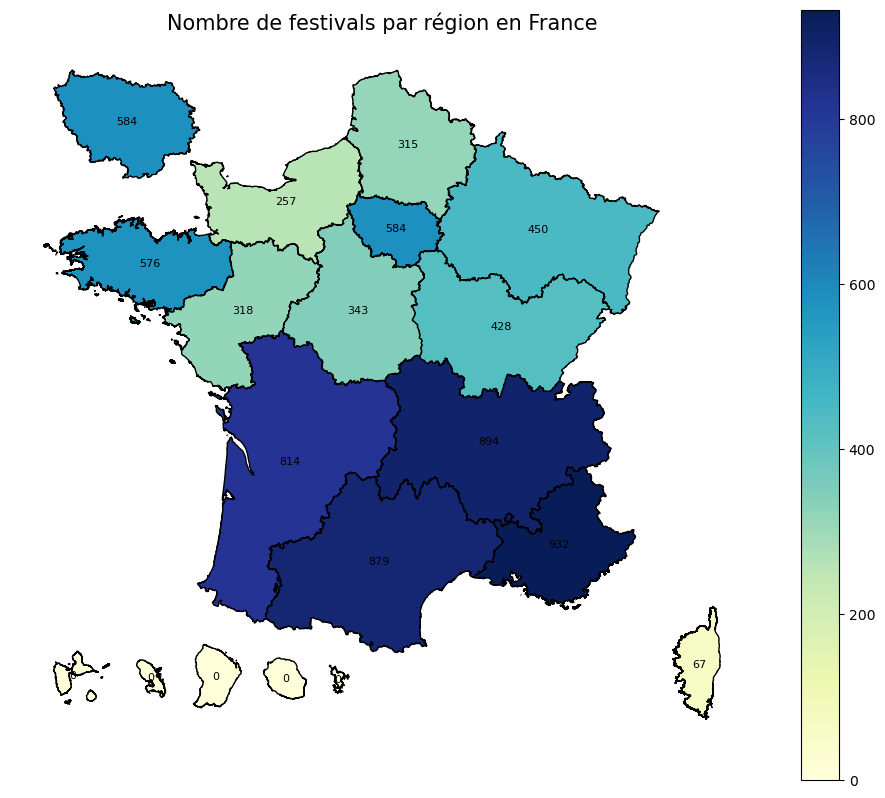

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Filtrer les données avec des régions valides
df_region = df.dropna(subset=["Région principale de déroulement"])

# Compter les festivals par région
region_counts = df_region['Région principale de déroulement'].value_counts().reset_index()
region_counts.columns = ['region', 'count']

# Récupérer les contours des régions
regions = carti_download(
    values="France",
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Joindre les données des festivals aux régions
regions = regions.merge(region_counts, left_on="LIBELLE_REGION", right_on="region", how="left")

# Remplacer les NaN par 0 (pour les régions sans festivals)
regions['count'] = regions['count'].fillna(0)

# Créer une carte des festivals par région
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
regions.plot(column="count", cmap="YlGnBu", legend=True, ax=ax, edgecolor="black")

# Ajouter les nombres de festivals sur la carte
for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):
    ax.text(x, y, str(int(label)), fontsize=8, ha='center', va='center', color='black')

# Ajouter le titre
plt.title("Nombre de festivals par région en France", fontsize=15)
plt.axis('off')  # Désactiver les axes
plt.show()


Après une première analyse, on peut remarquer que les régions du sud de la France sont celles ave le plus de festivals. On pourrait expliquer ceci (peut-être) par les festivals en plein air. La météo étant plus clémente dans ces régions de France. 
<br> On va ensuite regarder par rapport aux départements, puis comparer les festivals en plein air (ou que l'on estime en plein air) et ceux en intérieur (ou que l'on estime en intérieur).

### II.2. Répartition par départements

/tmp/ipykernel_366848/1712828113.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, departments['count']):


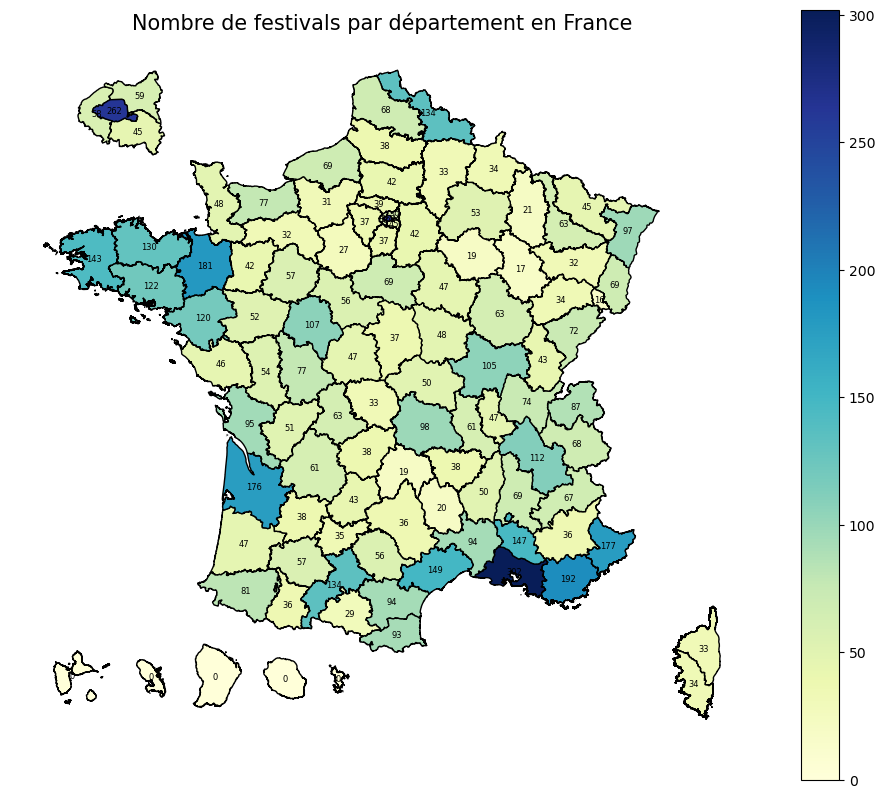

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download


# Filtrer les données avec des départements valides
df_department = df.dropna(subset=["Département principal de déroulement"])

# Compter les festivals par département
department_counts = df_department['Département principal de déroulement'].value_counts().reset_index()
department_counts.columns = ['department', 'count']

# Récupérer les contours des départements
departments = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Joindre les données des festivals aux départements
departments = departments.merge(department_counts, left_on="LIBELLE_DEPARTEMENT", right_on="department", how="left")

# Remplacer les NaN par 0 (pour les départements sans festivals)
departments['count'] = departments['count'].fillna(0)

# Créer une carte des festivals par département
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
departments.plot(column="count", cmap="YlGnBu", legend=True, ax=ax, edgecolor="black")

# Ajouter les nombres de festivals sur la carte
for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, departments['count']):
    ax.text(x, y, str(int(label)), fontsize=6, ha='center', va='center', color='black')

# Ajouter le titre
plt.title("Nombre de festivals par département en France", fontsize=15)
plt.axis('off')  # Désactiver les axes
plt.show()


La répartition par département ne nous permet pas forcément de déduire beaucoup d'information. Nous pouvons uniquement observer les départements avec le plus de festivals, avec une grosse densité dans le sud-est de la France ainsi que la Bretagne et l'île de France.
<br> Nous préférons alors une représentation suivant les régions dans ce qui suit.

### II.3. Répartition par régions suivant la catégorie de festival

/tmp/ipykernel_366848/4108199681.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):


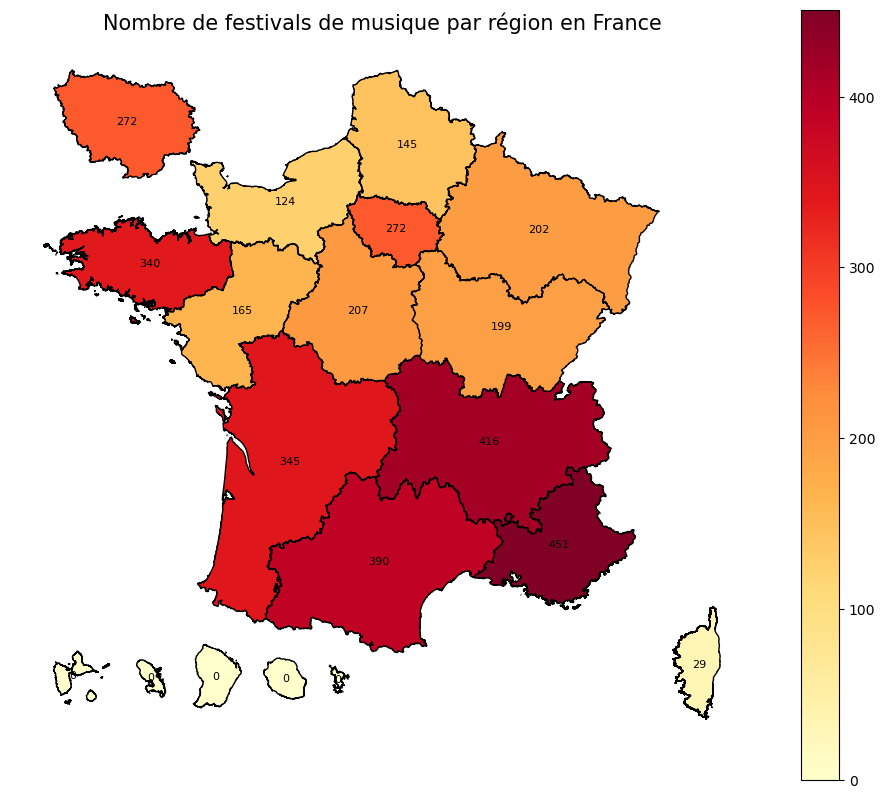

/tmp/ipykernel_366848/4108199681.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):


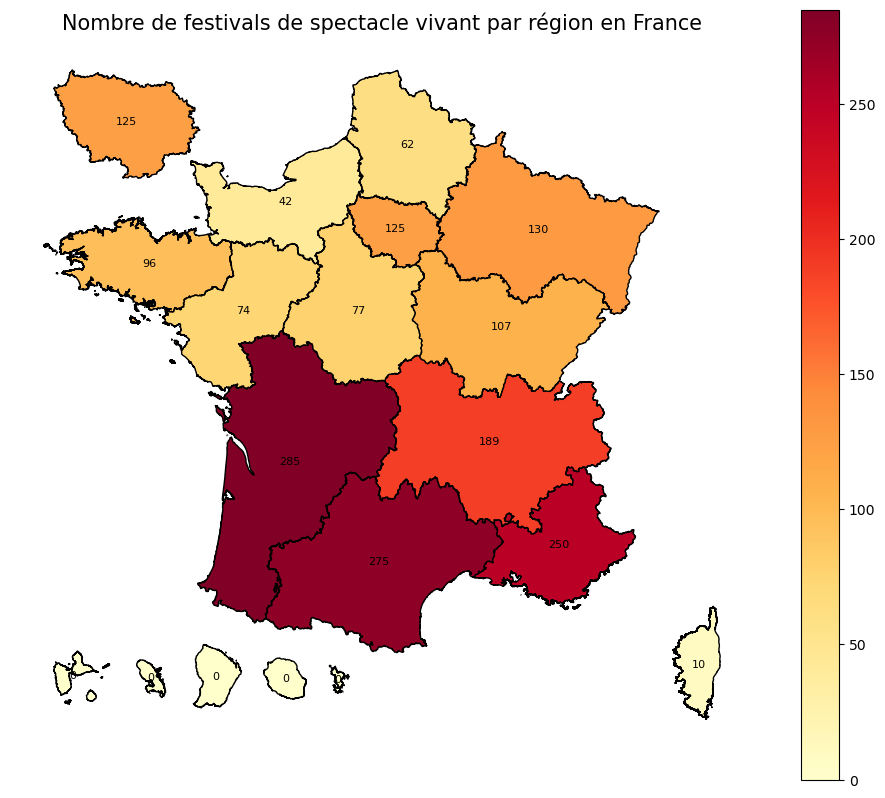

/tmp/ipykernel_366848/4108199681.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):


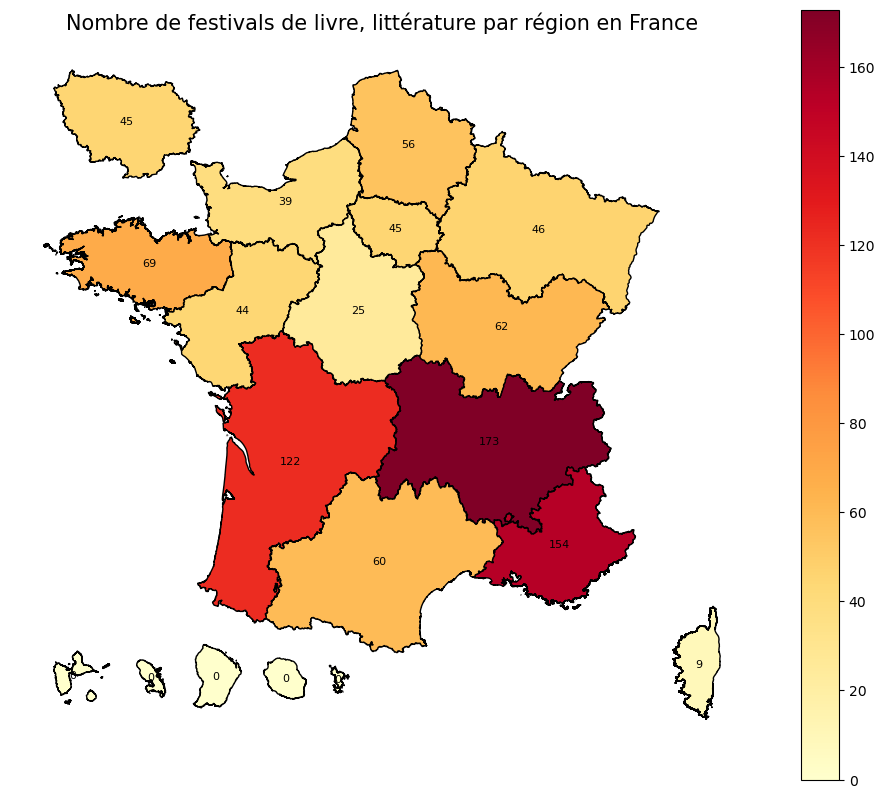

/tmp/ipykernel_366848/4108199681.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):


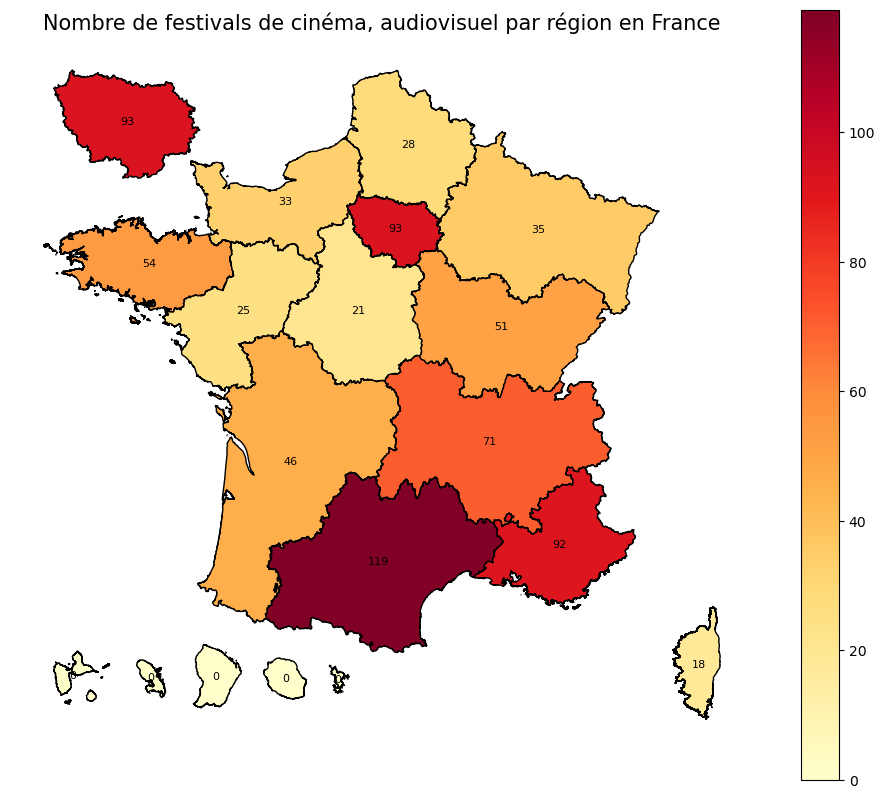

/tmp/ipykernel_366848/4108199681.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):


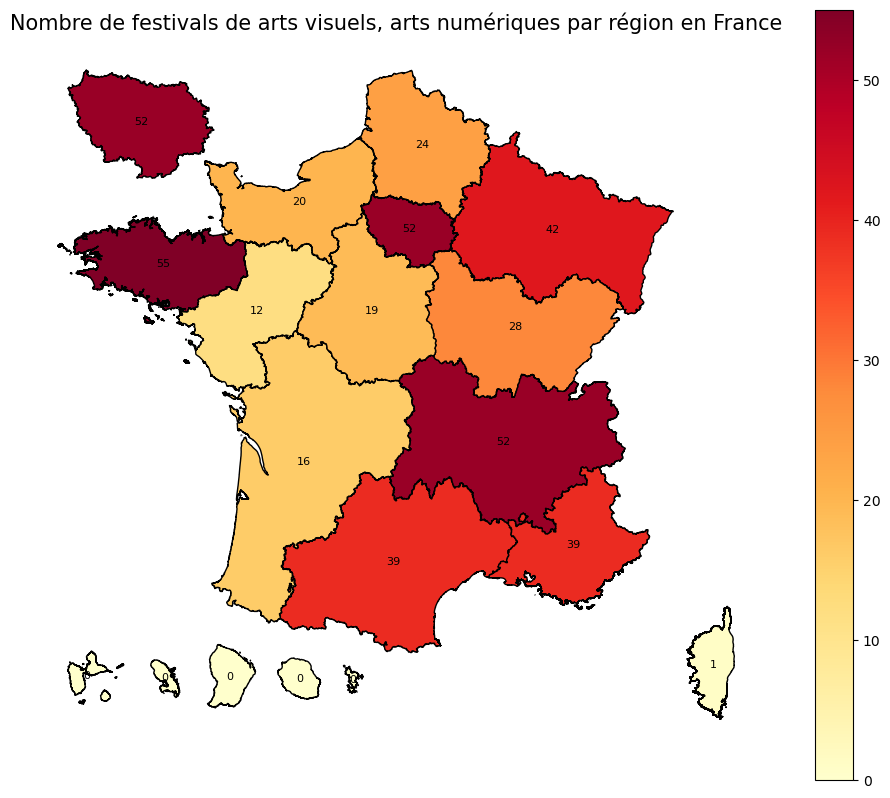

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Fonction pour créer une carte pour une catégorie spécifique
def plot_festival_map(category):
    # Filtrer les données avec des régions valides
    df_region = df.dropna(subset=["Région principale de déroulement"])
    
    # Filtrer les festivals pour inclure uniquement ceux qui contiennent la catégorie spécifiée dans "Discipline dominante"
    df_category = df_region[df_region["Discipline dominante"].str.contains(category, na=False)]
    
    # Compter les festivals de la catégorie par région
    region_counts_category = df_category['Région principale de déroulement'].value_counts().reset_index()
    region_counts_category.columns = ['region', 'count']
    
    # Récupérer les contours des régions
    regions = carti_download(
        values="France",
        crs=4326,
        borders="REGION",
        vectorfile_format="geojson",
        filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
        source="EXPRESS-COG-CARTO-TERRITOIRE",
        year=2022,
    )
    
    # Joindre les données des festivals aux régions
    regions = regions.merge(region_counts_category, left_on="LIBELLE_REGION", right_on="region", how="left")
    
    # Remplacer les NaN par 0 (pour les régions sans festivals de cette catégorie)
    regions['count'] = regions['count'].fillna(0)
    
    # Créer une carte des festivals de la catégorie par région
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    regions.plot(column="count", cmap="YlOrRd", legend=True, ax=ax, edgecolor="black")
    
    # Ajouter les nombres de festivals sur la carte
    for x, y, label in zip(regions.geometry.centroid.x, regions.geometry.centroid.y, regions['count']):
        ax.text(x, y, str(int(label)), fontsize=8, ha='center', va='center', color='black')
    
    # Ajouter le titre
    plt.title(f"Nombre de festivals de {category.lower()} par région en France", fontsize=15)
    plt.axis('off')  # Désactiver les axes
    plt.show()

# Liste des catégories de festivals
categories = ["Musique", "Spectacle vivant", "Livre, littérature", "Cinéma, audiovisuel", "Arts visuels, arts numériques"]

# Générer une carte pour chaque catégorie
for category in categories:
    plot_festival_map(category)

## III. Répartition en fonction de la date

Nous connaissons la saison à laquelle le festival a lieu :
- Avant saison (1er janvier - 20 juin)
- Saison (21 juin - 5 septembre)
- Après saison (6 septembre - 31 décembre)

Nous souhaitons donc analyser une relation possible entre la date du festival et le type de festival. 
<br> Dans un premier temps, nous allons uniquement nous concentrer sur le format du lieu (intérieur ou extérieur).
<br> Voici les festivals que nous considérons comme extérieur (catégorie (sous-catégorie)) : 
- Spectacle vivant (Arts de la rue)
- Arts visuels, arts numériques (Arts urbains)
- Musique (toutes les sous-catégories sauf Musique classique et opéra)

Nous considérons alors toutes les autres comme intérieur.

In [7]:
print(df.head())

            Nom du festival Envergure territoriale  \
0          Festival andalou              Régionale   
1  Festival Rêves d'enfants                    NaN   
3                 Pharaonic                    NaN   
4           Sarcus Festival                    NaN   
5          Jazz in Fougères                    NaN   

  Région principale de déroulement Département principal de déroulement  \
0       Provence-Alpes-Côte d'Azur                             Vaucluse   
1       Provence-Alpes-Côte d'Azur                         Hautes-Alpes   
3             Auvergne-Rhône-Alpes                               Savoie   
4              Centre-Val de Loire                       Indre-et-Loire   
5                         Bretagne                      Ille-et-Vilaine   

  Commune principale de déroulement       Site internet du festival  \
0                           Avignon  https://lefestivalandalou.com/   
1                          Briançon         www.serre-chevalier.com   
3          

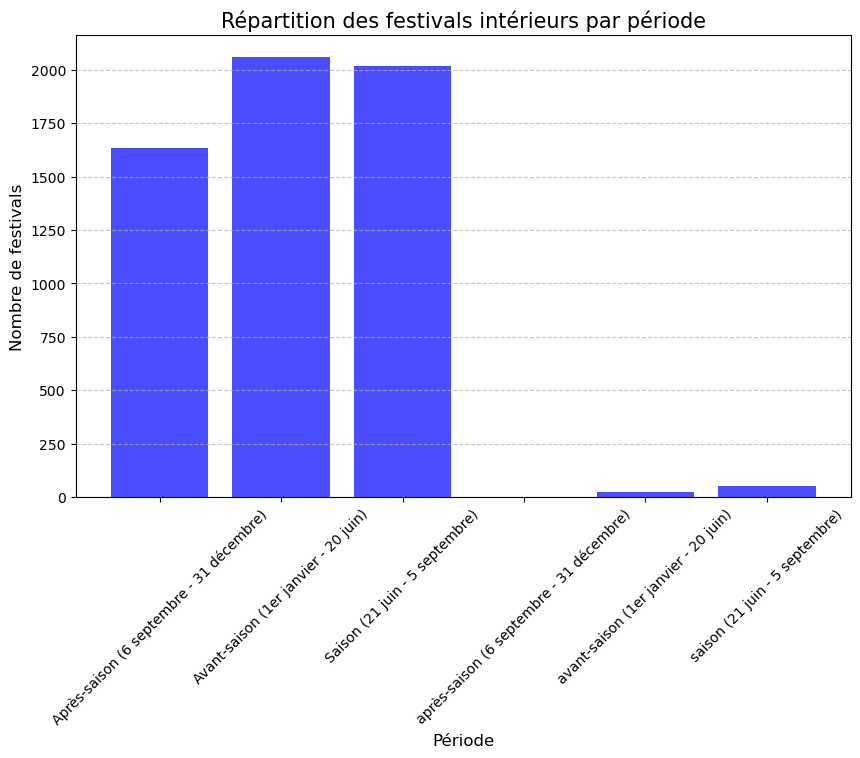

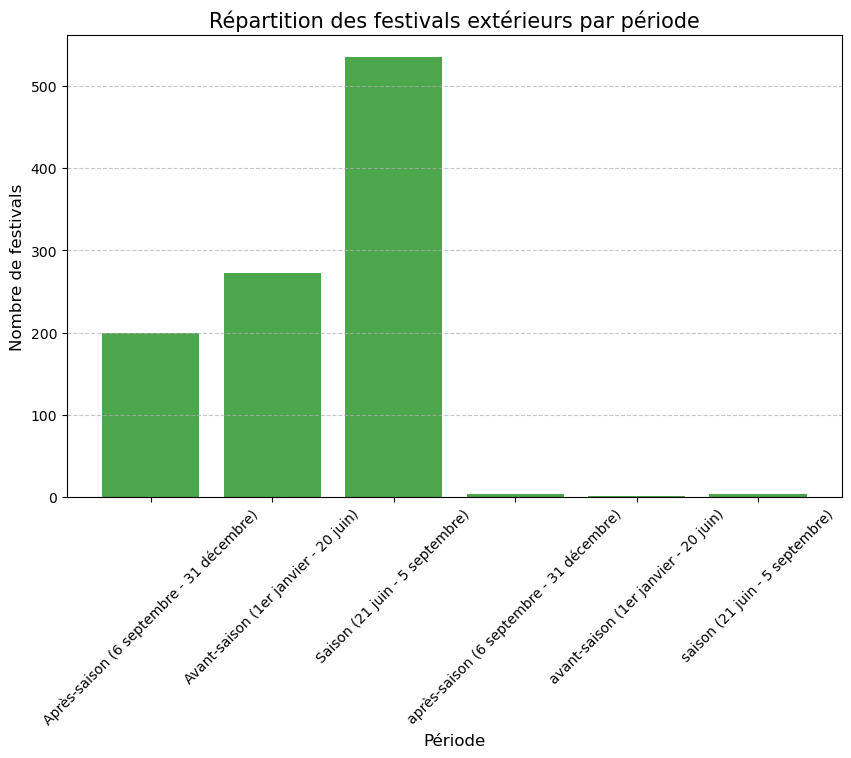

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Identification des festivals extérieurs
def determiner_type_festival(row):
    """
    Détermine si un festival est intérieur ou extérieur.
    """
    categories_ext = {
        "Spectacle vivant": ["Arts de la rue"],
        "Arts visuels, arts numériques": ["Arts urbains"],
        "Musique": [
            "Musiques amplifiées ou électroniques",
            "Musiques actuelles",
            "Musiques du monde",
            "Jazz, blues, RnB",
            "Musiques folk et patrimoniales",
            "Musiques électroniques, techno",
            "Pop/rock",
        ],
    }
    
    # Parcourir les catégories et leurs sous-catégories
    for cat, sous_cats in categories_ext.items():
        if cat in row["Discipline dominante"]:
            sous_categorie_col = f"Nouvelles sous-catégories {cat.lower().replace(', ', '_').replace(' ', '_')}"
            if sous_categorie_col in row.index:
                sous_cats_festival = row[sous_categorie_col]
                if isinstance(sous_cats_festival, list):  # Si c'est une liste
                    if any(sous_cat in sous_cats_festival for sous_cat in sous_cats):
                        return "Extérieur"
    
    # Si aucune correspondance trouvée
    return "Intérieur"

# Appliquer la fonction pour déterminer le type de chaque festival
df["Type"] = df.apply(determiner_type_festival, axis=1)

# Comptage des festivals par période et type
comptage = df.groupby(["Période principale de déroulement du festival", "Type"]).size().reset_index(name="Nombre")

# Données pour les festivals intérieurs
data_interieur = comptage[comptage["Type"] == "Intérieur"]

# Données pour les festivals extérieurs
data_exterieur = comptage[comptage["Type"] == "Extérieur"]

# Création du graphique pour les festivals intérieurs
plt.figure(figsize=(10, 6))
plt.bar(data_interieur["Période principale de déroulement du festival"], data_interieur["Nombre"], color="blue", alpha=0.7)
plt.title("Répartition des festivals intérieurs par période", fontsize=15)
plt.xlabel("Période", fontsize=12)
plt.ylabel("Nombre de festivals", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# Création du graphique pour les festivals extérieurs
plt.figure(figsize=(10, 6))
plt.bar(data_exterieur["Période principale de déroulement du festival"], data_exterieur["Nombre"], color="green", alpha=0.7)
plt.title("Répartition des festivals extérieurs par période", fontsize=15)
plt.xlabel("Période", fontsize=12)
plt.ylabel("Nombre de festivals", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.show()
